In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import RELACS as rel
sns.set_style("white")
sns.set_context("paper")
%matplotlib inline
%load_ext rpy2.ipython

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### RETRIEVE COVERAGE ON MERGED PEAK SET ACROSS ALL ASSAYS

In [2]:
%%bash

### COUNT READS IN PEAKS FOR EACH SAMPLE IN THE OVERALL MERGED PEAK SET

SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_demultiplexed/"

#ls $SNAKEPIPE_OUTDIR/filtered_bam/AD_*_H3*.filtered.bam 

multiBamSummary BED-file -b $SNAKEPIPE_OUTDIR/filtered_bam/AD_*_H3*.filtered.bam \
-o ../intermediate_files/ChIP-seq_counts_onConsensusAllMarks.npz \
--BED ../intermediate_files/Merged_Peaks_allMarks.bed \
--outRawCounts ../intermediate_files/ChIP-seq_counts_onConsensusAllMarks.counts \
-p 20 \
--minMappingQuality 3 \
-e

Number of bins found: 15896


### TRANSFORM COUNTS IN RLOG MATRIX USING DESEQ2

In [3]:
%%R

##########################################
### CREATE RLOG NORMALIZED COUNT TABLE ###
##########################################

lib_ = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5"

library(DESeq2, lib = lib_)

### IMPORT COUNTS ###
count=read.csv("../intermediate_files/ChIP-seq_counts_onConsensusAllMarks.counts", sep='\t', header = T)
rownames(count) = paste(count[,1],count[,2],count[,3], sep="_")
count[,c(1,2,3)]=NULL
keep_cols = colSums(count) >= 10000
count =  count[,keep_cols]
print(dim(count))
# ### CREATE DESIGN TABLE ###
design_table=data.frame(row.names = colnames(count),
                        condition = rep(c(rep("Biomek",3),rep("Manual",3)),29))

# ### CREATE DDS OBJECT ###
dds <- DESeqDataSetFromMatrix(countData = count,
                             colData = design_table,
                             design = ~ condition)

### PREFILTERING ###
keep_rows = rowSums(counts(dds)) >= 10
dds = dds[keep_rows,]
print(dim(assay(dds)))

# ### CREATE RLOG TRANSFORMATION OF COUNT DATA ### 
rld = rlog(dds, blind=FALSE)
write.table(assay(rld), "../intermediate_files/RLD_counts_AllMarks_onConsensus.tsv", sep="\t", quote=F)



/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘pac

[1] 15896   174
[1] 15896   174


### COMPUTE PCA AND PLOT RESULTS

Number of barcodes: 28
Total number of experiments: 168


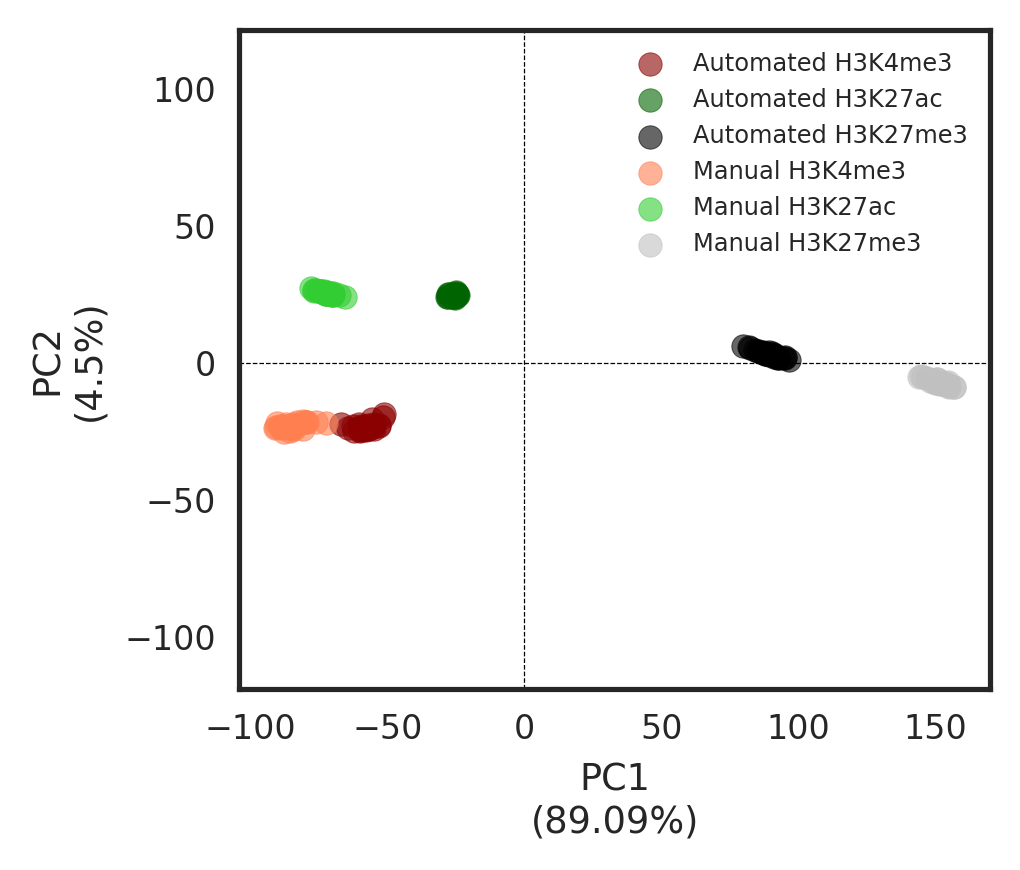

In [15]:
# IMPORT RLOG MATRIX ###
rlog_ = pd.read_csv("../intermediate_files/RLD_counts_AllMarks_onConsensus.tsv",sep="\t", index_col=0)
print("Number of barcodes: {}\nTotal number of experiments: {}".format(int(rlog_.shape[1]/6), rlog_.shape[1]))

### select most variable peaks ###

top_var = rlog_.var(axis=1).sort_values(ascending=False)[0:10000].index
rlog = rlog_.loc[top_var].T
rlog
### PERFORM PCA ###
pca = PCA()
pca_data = pca.fit_transform(rlog)

labels = ["PC{}".format(i) for i in range(pca_data.shape[1]+1)[1:]]
pca_df = pd.DataFrame(pca_data, index = list(rlog_), columns=labels)
dic_col = {"Biomek_H3K4me3":'darkred',
           "Biomek_H3K27ac":'darkgreen',
           "Biomek_H3K27me3":'black',
           "manual_H3K4me3":'coral',
           "manual_H3K27ac":'limegreen',
           "manual_H3K27me3":'silver'}
# pca_df['color'] = [dic_col["_".join(i.split("_")[2:4]).split(".")[0]] for i in pca_df.index]
pca_df['class'] = ["_".join(i.split("_")[2:4]).split(".")[0] for i in pca_df.index]

### PLOT PCA AND SAVE ###
fig,ax=plt.subplots(dpi=300, figsize=(3.5,3))
labels_plot={"Biomek_H3K4me3":'Automated H3K4me3',
             "Biomek_H3K27ac":'Automated H3K27ac',
             "Biomek_H3K27me3":'Automated H3K27me3',
             "manual_H3K4me3":'Manual H3K4me3',
             "manual_H3K27ac":'Manual H3K27ac',
             "manual_H3K27me3":'Manual H3K27me3'}
ax.axis('equal')
for i in dic_col:
    ax.scatter(pca_df["PC1"].loc[pca_df["class"]==i], pca_df["PC2"].loc[pca_df["class"]==i],color=dic_col[i],label=labels_plot[i], alpha=0.6)
ax.set_xlabel("PC1\n({}%)".format(round(pca.explained_variance_ratio_[0]*100,2)))
ax.set_ylabel("PC2\n({}%)".format(round(pca.explained_variance_ratio_[1]*100,2)))

ax.axvline(0, linestyle='--', linewidth=0.3, color='k')
ax.axhline(0, linestyle='--', linewidth=0.3, color='k')
ax.legend(fontsize="xx-small")
plt.tight_layout()
plt.savefig("../figures/PCA_allSamples_demultiplexed.png")